In [2]:
import pandana, time, os, pandas as pd, numpy as np, osmnx as ox

In [3]:
#pip install pandana --user

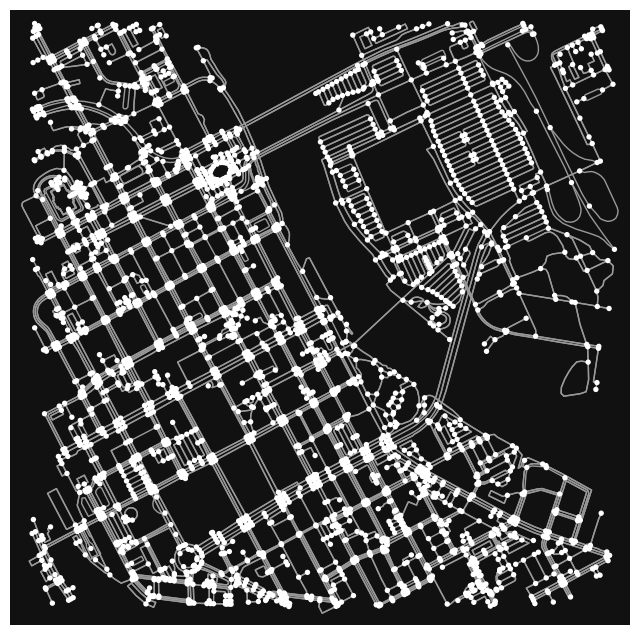

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [4]:
G = ox.graph_from_address('Nashville, Tennessee')
ox.plot_graph(G)

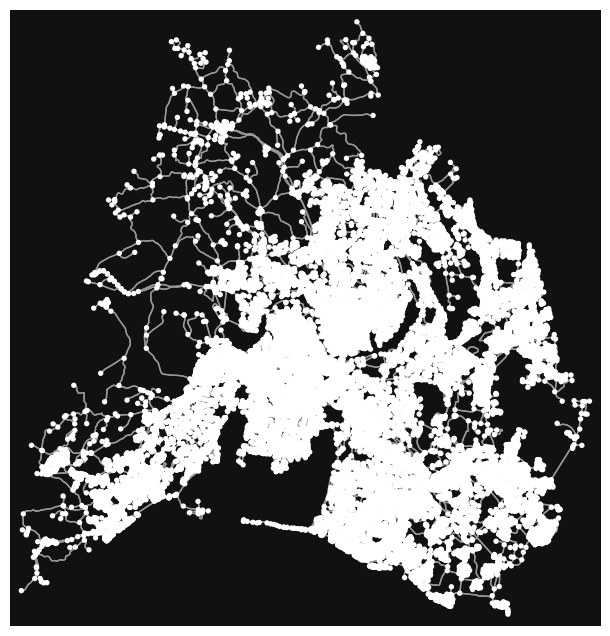

In [38]:
H = ox.graph_from_place("Nashville, Tennessee", network_type="drive")
fig, ax = ox.plot_graph(H)

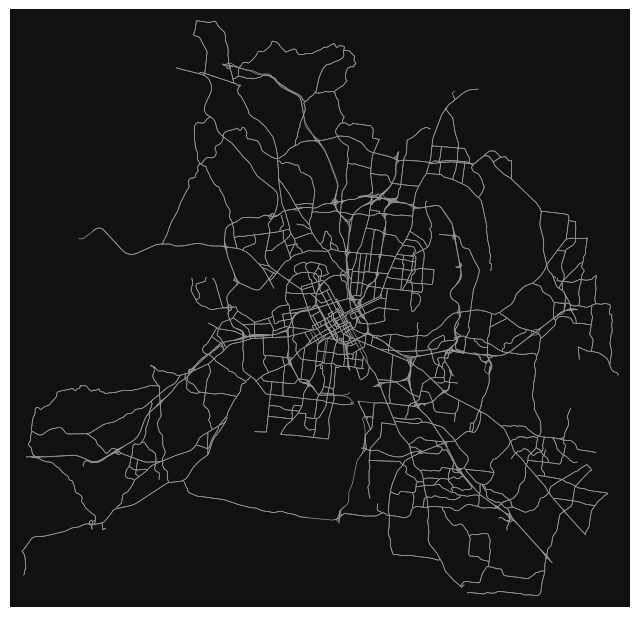

In [39]:
place = "Nashville, Tennessee"
cf = '["highway"~"motorway|trunk|primary|secondary|tertiary"]'
highways = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
fig, ax = ox.plot_graph(highways, node_size=0, edge_linewidth=0.5)

In [40]:
place = ["Berlin, Germany"]
G = ox.graph_from_place(place, retain_all=True, simplify = True, network_type='all')

In [49]:
from pandana.loaders import osm

# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
amenities = ['restaurant', 'bar', 'school']
distance = 1000
num_pois = 10
num_categories = len(amenities) + 1 #one for each amenity, plus one extra for all of them combined

# bounding box as a list of llcrnrlat, llcrnrlng, urcrnrlat, urcrnrlng
#bbox = [36.16, -86.77, 36.155, -86.77] #lat-long bounding box for dt nashville
bbox = [37.76, -122.35, 37.9, -122.17] #lat-long bounding box for berkeley/oakland

In [50]:
# configure filenames to save/load POI and network datasets
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = '../data/network_{}.h5'.format(bbox_string)
poi_filename = '../data/nashpois_{}_{}.csv'.format('_'.join(amenities), bbox_string)

In [51]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

In [52]:
start_time = time.time()
if os.path.isfile(poi_filename):
    # if a points-of-interest file already exists, just load the dataset from that
    pois = pd.read_csv(poi_filename)
    method = 'loaded from CSV'
else:   
    # otherwise, query the OSM API for the specified amenities within the bounding box 
    osm_tags = '"amenity"~"{}"'.format('|'.join(amenities))
    pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags=osm_tags)
    
    # using the '"amenity"~"school"' returns preschools etc, so drop any that aren't just 'school' then save to CSV
    pois = pois[pois['amenity'].isin(amenities)]
    pois.to_csv(poi_filename, index=False, encoding='utf-8')
    method = 'downloaded from OSM'
    
print('{:,} POIs {} in {:,.2f} seconds'.format(len(pois), method, time.time()-start_time))
pois[['amenity', 'name', 'lat', 'lon']].head()

1,105 POIs loaded from CSV in 0.04 seconds


,amenity,name,lat,lon
0,restaurant,Mountain Mike's,37.826927,-122.209567
1,restaurant,Berkeley Thai House,37.867150,-122.258297
2,restaurant,Fish & Bird Sousaku Izakaya,37.864796,-122.267140
3,restaurant,Pat Brown's Grille,37.873327,-122.264884
4,restaurant,Homemade Cafe,37.862263,-122.281359


In [53]:
# how many points of interest of each type of amenity did we retrieve?
pois['amenity'].value_counts()

restaurant    915
bar           117
school         73
Name: amenity, dtype: int64

In [36]:
start_time = time.time()
if os.path.isfile(net_filename):
    # if a street network file already exists, just load the dataset from that
    network = pandana.network.Network.from_hdf5(net_filename)
    method = 'loaded from HDF5'
else:
    # otherwise, query the OSM API for the street network within the specified bounding box
    network = osm.network_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3])
    method = 'downloaded from OSM'
    
    # identify nodes that are connected to fewer than some threshold of other nodes within a given distance
    lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
    network.save_hdf5(net_filename, rm_nodes=lcn) #remove low-connectivity nodes and save to h5
    
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

AttributeError: module 'pandana.loaders.osm' has no attribute 'network_from_bbox'